In [1]:
import sys
sys.path.append('../')

import joint_optim_utils, optim_utils, plot_utils
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
WYSCOUT_ID = 5414111
SKILLCORNER_ID = 952209

NETWORKS_PATH = f'../../data/networks/match_{SKILLCORNER_ID}/'
PASSES_DF_PATH = NETWORKS_PATH + 'passes_df.csv'

DATA_PATH= f'../../data/'
XT_PLOT_PATH = DATA_PATH + 'smoothed_xt.csv'
METADATA_PATH = DATA_PATH + f'skillcorner/{SKILLCORNER_ID}_metadata.csv'

In [3]:
passes_df = pd.read_csv(PASSES_DF_PATH)

In [4]:
xt_table = pd.read_csv(XT_PLOT_PATH)
pitch_length, pitch_width = pd.read_csv(METADATA_PATH)[['pitch_length', 'pitch_width']].values[0]
threat_map = optim_utils.ThreatMap(xt_table, pitch_length, pitch_width)

In [5]:
negative_frames = optim_utils.all_negative_dxt_frames(passes_df, threat_map)
passes_df = passes_df[~passes_df['frame'].isin(negative_frames)]

# Visualize Player Locations

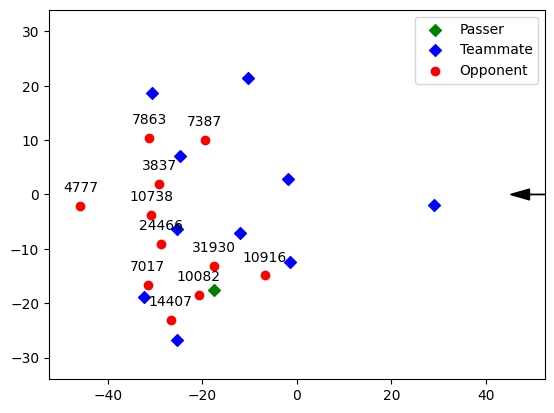

In [6]:
# frame_id = np.random.choice(passes_df['frame'].unique())
frame_id = 31966
pass_plotter = plot_utils.PassPlotter(passes_df, frame_id, pitch_length, pitch_width)
pass_plotter.plot_players()

# Optimize Location

In [7]:
from skopt import gp_minimize, dummy_minimize
from skopt.plots import plot_convergence

In [8]:
frame_id = 31966

In [9]:
threat_func = joint_optim_utils.create_joint_xt_func_vectorized(passes_df, frame_id, threat_map)
threat_agg = optim_utils.threat_aggregator('softmax', temp=0.03)
opt_func = lambda x: -threat_agg(threat_func(x))

pass_plotter = plot_utils.PassPlotter(passes_df, frame_id, pitch_length, pitch_width)

radius = 2

_,_,defenders_info,_ = optim_utils.retrieve_player_positions(passes_df, frame_id)
x_init = list(joint_optim_utils.extract_defender_positions(defenders_info))
bounds = joint_optim_utils.generate_bounds(x_init, radius)

opt_func_neg = lambda x: -opt_func(x)
res = gp_minimize(opt_func_neg, 
                  bounds,
                  acq_func="gp_hedge",     
                  n_calls=30,         
                  n_random_starts=10,
                  random_state=1234,
                  x0=x_init) 

x_opt = res.x
results = joint_optim_utils.joint_optimization_report(opt_func, x_init, x_opt)
for k,v in results.items():
    print(f'{k}: {v}')

init_val: -0.0007774097691222137
opt_val: 0.001651889818629253
improvement: 0.0024292995877514666
improvement_perc: 312.48637259786807
avg_distance: 2.4440302211523437


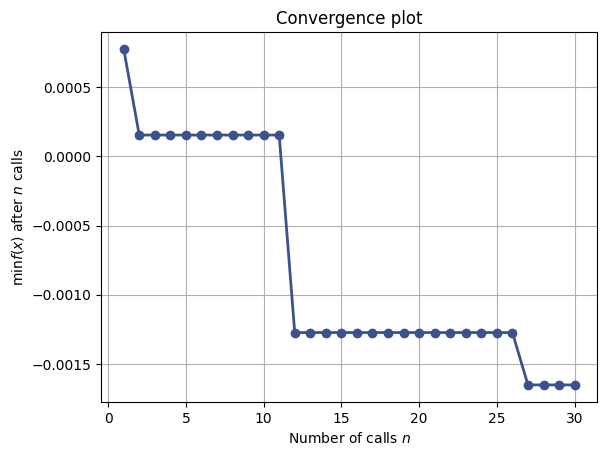

In [10]:
plot_convergence(res)
plt.show()

In [11]:
defenders_init = joint_optim_utils.update_defenders_info(defenders_info, x_init)
defenders_opt = joint_optim_utils.update_defenders_info(defenders_info, x_opt)

positions, ids = pass_plotter.get_attacker_locations(include_ids=True)
attackers = {}
for id, pos in zip(ids, positions):
    attackers[id] = {'location': tuple(pos)}
    
ball_owner = {'location': (pass_plotter.passer_x, pass_plotter.passer_y)}

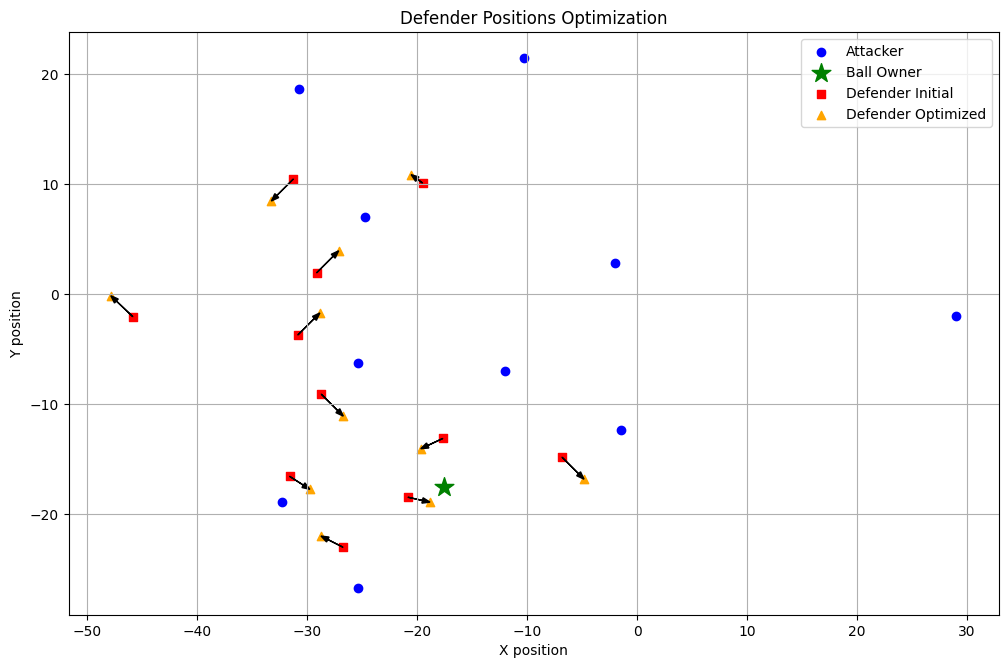

In [12]:
joint_optim_utils.visualize_positions_optimization(attackers, ball_owner, defenders_init, defenders_opt)